# Traffic Time Series

# Introduction

Hello! My name is Evan Freeman. Let's analyze a time series. "Time Series" means that we are given some piece of information, in this case count of traffic, at a specific date and time. It is our job as a Data Scientist to unpack that date and time into many valuable piece of information and look for patterns to help us predict future behavior.

Here's the competition I'm working on with this dataset:

https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/

We're given a time series which records the number of users for a new public transit system every hour over the course of 2 years. We must create a predictive model for what future passenger count will be.

# Setup

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv
import warnings
from itertools import permutations

warnings.filterwarnings('ignore')

filepath = 'D:/code/Data/time_series_datahack/'

data = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')
sample = pd.read_csv(f'{filepath}sample_submission.csv')

# Data Exploration

In [2]:
display(data)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


In [3]:
display(test)

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00
...,...,...
5107,23395,26-04-2015 19:00
5108,23396,26-04-2015 20:00
5109,23397,26-04-2015 21:00
5110,23398,26-04-2015 22:00


There's only 1 input and 1 output. While that may not seem like a lot, but we can actually generate a great many features, such as: Year, Month, Day, Hour, lag, etc.

In [4]:
data.describe()

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


# Data Cleaning

In [5]:
display(data.isnull().sum())

ID          0
Datetime    0
Count       0
dtype: int64

Nice! No missing data. Easy Mode!

# Feature Generation

Let's do some feature generation:  
1. Year
2. Month
3. Day of the month
4. Hour
5. Day of the week
6. Day of the year
7. Week of the year

We could also look at more complex features, such as lag, which is the count of cars previous to a given time. But for now we'll focus on the listed features.

In [6]:
# First, convert from string to the datetime object in Pandas.
data['Datetime'] = pd.to_datetime(data['Datetime'], format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'], format = '%d-%m-%Y %H:%M')


def domain_features(df):
    """ 
    Generates the following features from a given datetime:
    
    Year (2012-2014)
    Month (1-12)
    Day of the Month (i.e. date, 1-31)
    Hour (0-23)
    Day of the Week (0-6)
    Day of the Year (1-366)
    Week of the Year (1-52)
    """
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Dayofmonth'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    df['Dayofweek'] = df['Datetime'].dt.dayofweek
    df['Dayofyear'] = df['Datetime'].dt.dayofyear
    df['Week'] = df['Datetime'].dt.week
    
domain_features(data)
domain_features(test)

In [7]:
data

,ID,Datetime,Count,Year,Month,Dayofmonth,Hour,Dayofweek,Dayofyear,Week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,238,34
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,238,34
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,238,34
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,238,34
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,238,34
...,...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,268,39
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,268,39
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,268,39
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,268,39


In [8]:
test

,ID,Datetime,Year,Month,Dayofmonth,Hour,Dayofweek,Dayofyear,Week
0,18288,2014-09-26 00:00:00,2014,9,26,0,4,269,39
1,18289,2014-09-26 01:00:00,2014,9,26,1,4,269,39
2,18290,2014-09-26 02:00:00,2014,9,26,2,4,269,39
3,18291,2014-09-26 03:00:00,2014,9,26,3,4,269,39
4,18292,2014-09-26 04:00:00,2014,9,26,4,4,269,39
...,...,...,...,...,...,...,...,...,...
5107,23395,2015-04-26 19:00:00,2015,4,26,19,6,116,17
5108,23396,2015-04-26 20:00:00,2015,4,26,20,6,116,17
5109,23397,2015-04-26 21:00:00,2015,4,26,21,6,116,17
5110,23398,2015-04-26 22:00:00,2015,4,26,22,6,116,17


# Data Plotting

It is often helpful to plot the data and look for patterns before modeling.

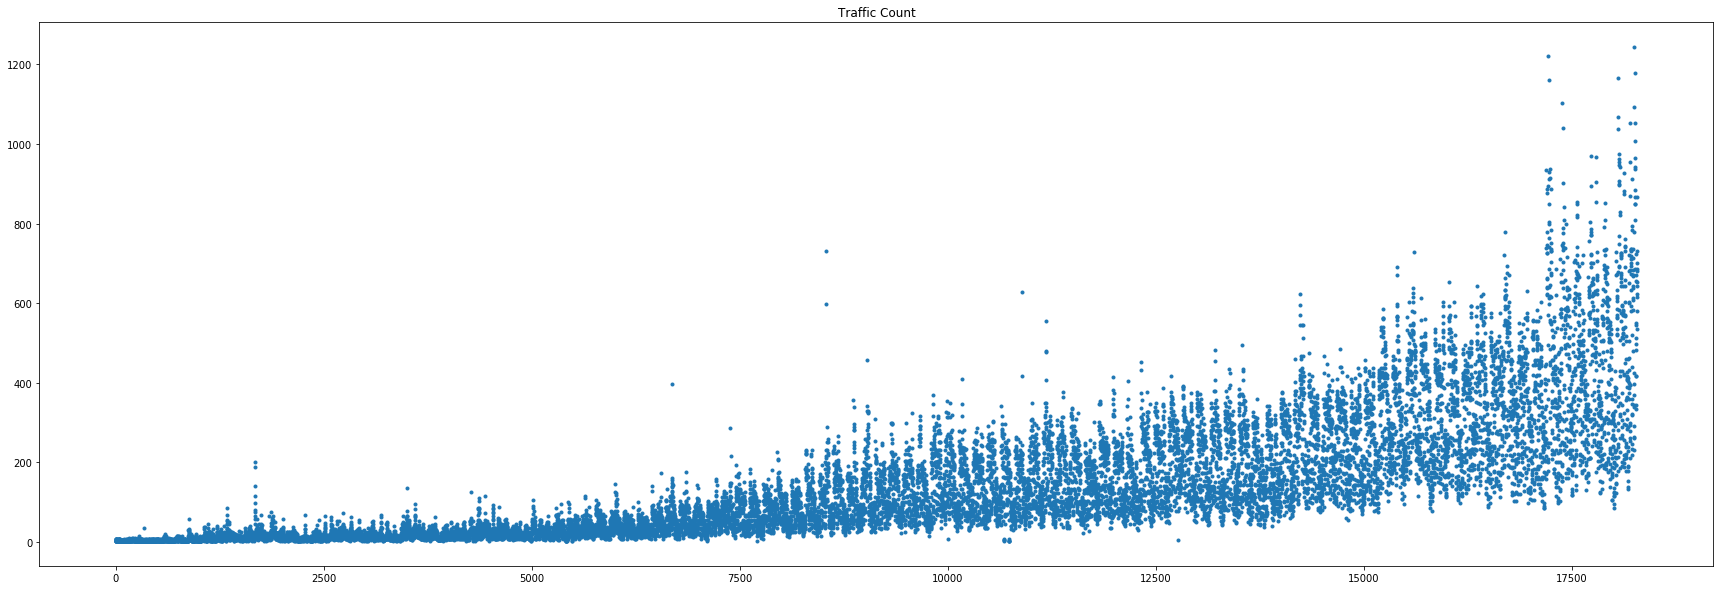

In [9]:
plt.figure(figsize = (30, 10))
data.Count.plot(style = '.')
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

Here we can see some clear trends:
1. Increase in average count over time
2. Increase in variance of count over time

<Figure size 720x720 with 0 Axes>

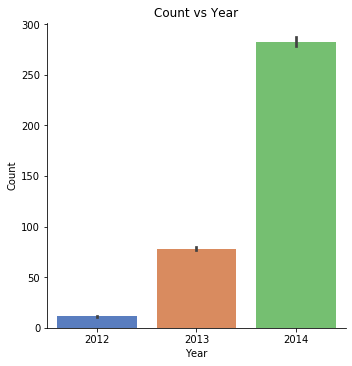

<Figure size 720x720 with 0 Axes>

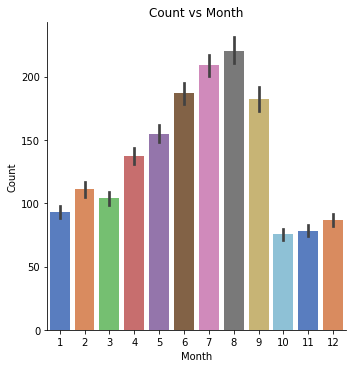

<Figure size 720x720 with 0 Axes>

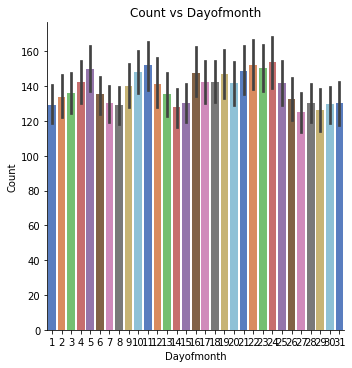

<Figure size 720x720 with 0 Axes>

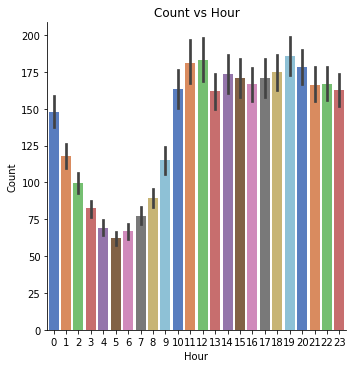

<Figure size 720x720 with 0 Axes>

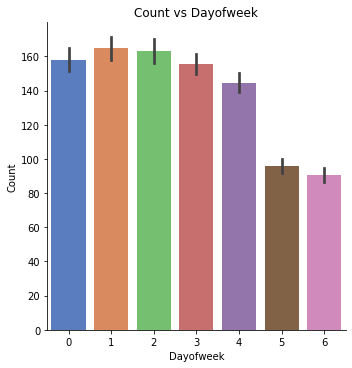

<Figure size 720x720 with 0 Axes>

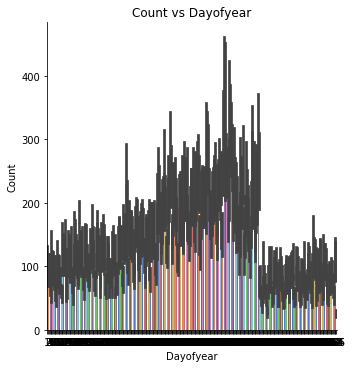

<Figure size 720x720 with 0 Axes>

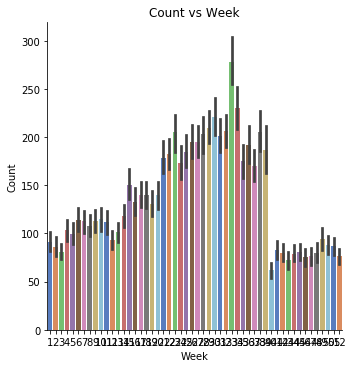

In [10]:
for feature in data.loc[:, 'Year':]:

    plt.figure(figsize = (10, 10))
    graph = sns.catplot(x = feature, y = 'Count', hue = None, data = data, kind="bar", palette="muted")
    plt.title(f'Count vs {feature}')
    plt.show();

## Plot Conclusions

1. Count vs. Year is not particularly helpful, as neither 2012 nor 2014 is a complete year in the data. Nonetheless, it's clear that there was substantial growth from 2013 to 2014.
2. Unfortunately, because of the incomplete nature of the data, many of these graphs are worthless. There is no 2014 data for October, November, or Decemeber. Yet 2014 had by far the largest counts. So the following graphs have huge discrepencies: 
  - Count vs. Month
  - Count vs. Dayofyear
  - Count vs. Week
3. Count vs. Day of Month has no obvious trends, except perhaps a slight dip at the beginning and end of each month.
4. Count vs. Hour is very interesting. There's a clear dip in the late night / early evening, indicating the time of minimal activity (presumable when most people are sleeping). And there are two areas that are slightly higher, which might correspond with rush hours.
5. Count vs. Dayofweek shows a clear dip on the weekend, and a slight rise in the middle of the week.

# Model Training

We will look at a variety of models and see what results we get. Note that we do not need to split test data, as the competition has furnished us with test data.
We will just split of validation data for training our models.

In [11]:
train, valid = train_test_split(data, shuffle = True, test_size = .2)

X_train = train.loc[:, 'Year':]
y_train = train.loc[:, 'Count']

X_valid = valid.loc[:, 'Year':]
y_valid = valid.loc[:, 'Count']

display(X_train)
display(X_valid)

,Year,Month,Dayofmonth,Hour,Dayofweek,Dayofyear,Week
12350,2014,1,21,14,1,21,4
18164,2014,9,20,20,5,263,38
17900,2014,9,9,20,1,252,37
669,2012,9,21,21,4,265,38
9256,2013,9,14,16,5,257,37
...,...,...,...,...,...,...,...
3747,2013,1,28,3,0,28,5
3569,2013,1,20,17,6,20,3
11642,2013,12,23,2,0,357,52
9172,2013,9,11,4,2,254,37


,Year,Month,Dayofmonth,Hour,Dayofweek,Dayofyear,Week
506,2012,9,15,2,5,259,37
907,2012,10,1,19,0,275,40
14995,2014,5,11,19,6,131,19
5276,2013,4,1,20,0,91,14
1102,2012,10,9,22,1,283,41
...,...,...,...,...,...,...,...
4308,2013,2,20,12,2,51,8
8440,2013,8,11,16,6,223,32
5234,2013,3,31,2,6,90,13
9143,2013,9,9,23,0,252,37


## Model 0: Random

It is important to have a baseline model for comparison. Let's begin with a random model and see if we can beat that!

In [12]:
# The max count in the data is 1244
valid_pred = np.random.randint(0, 1245, size = (3658))

error = np.sqrt(mse(valid_pred, y_valid))
mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the model is {error:.2f}')
display(f'Percent Error for the model is {percent_error:.2f}%')

predict = np.random.randint(0, 1245, size = (5112))

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit0.csv',index=False, header =1)

'RMSE for the model is 621.46'

'Percent Error for the model is 447.23%'

Classic 450% error. Hopefully we can beat that!

We got RMSE of 446.91 when we uploaded. So, a bit better than we hoped! In reality, that means nothing, as it is random.

In general we would look at many different models, like linear regression, decision tree, and random forest. But for the sake of time I'm only going to consider two boosting models: LightGBM and XGBoost.

## Model 1: Boosting with LightGBM

In [13]:
model = lgb.LGBMRegressor(num_iterations = 5000)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the model is {error:.2f}')
display(f'Percent Error for the model is {percent_error:.2f}%')

'RMSE for the model is 28.26'

'Percent Error for the model is 20.33%'

Well, not terrible for a basic model, but hopefully we can do a bit better.

Still, let's see how we're doing so far. Let's retrain on the whole data, and do a submission to the website. It will score our test predictions.

In [14]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit1.csv',index=False, header =1)

This yielded a RMSE of 138 on website. Higher than we were predicting, but still good considering the incomplete data given. That puts us at 12 on the leaderboard.

# Feature Importance

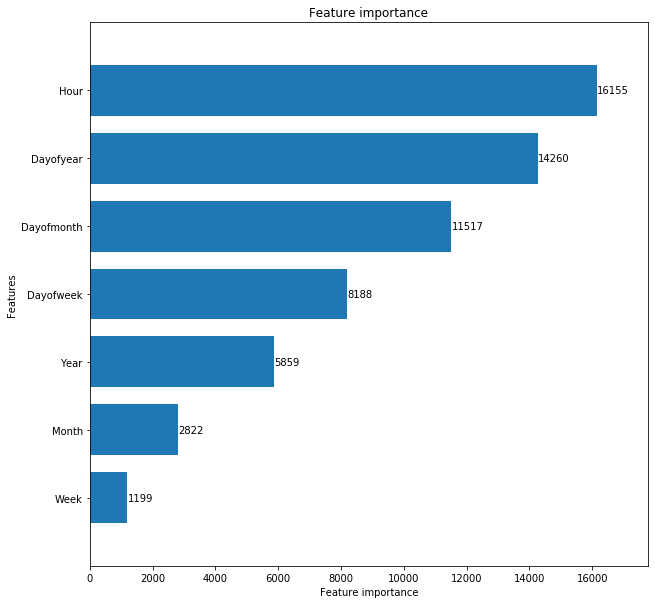

In [15]:
lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

## Comments

Looking over the feature importance, we can draw some conclusions:

1. Time of day is the most important. This makes sense, as there are obvious patters of traffic throughout the day, most notable people commuting in and out of work. We saw this on the graph above.
2. Next most important is the Day of the Year. This covers things like holidays.
3. It's unclear why dayofmonth is so important, but perhaps its based on the trend I noticed of dips at the beginning and end of each month.
4. Dayofweek has clear dips for the weekend, so it makes sense the model would use this.
5. Year, which incomplete, shows a clear increase from 2012-2014.
6. Month and Week are predictable not very important for the model, as they show incomplete, and likely contradictory data, to the other features.

# LightGBM Random Search

Now let's try to optimize our model with a little hyperparameter tuning. One nice thing is that the sklearn random search has built in cross validation, so we don't need to split our data.

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 302 tasks      | elapsed:   20.7s
[Parallel(n_jobs=2)]: Done 802 tasks      | elapsed:   52.4s
[Parallel(n_jobs=2)]: Done 1502 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 2402 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 3502 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 4802 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed:  5.4min finished


Best score reached: -87.14149420111355 NRMSE with params: {'num_leaves': 6, 'n_estimators': 274, 'learning_rate': 0.1} 


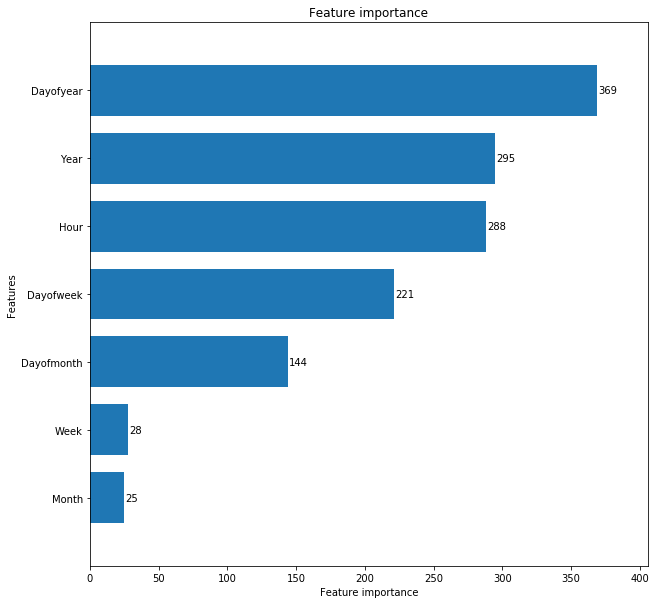

In [16]:
# Here we'll use the whole training set, and cross validate with the random search cross validate function

X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']
X_test = test.loc[:, 'Year':]

param_test = {
                'num_leaves': range(2, 10), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(200, 400, 1)
            }

num_iter = 1000

model = lgb.LGBMRegressor(silent=True, n_jobs=3, verbose = -1)

rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = num_iter,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} NRMSE with params: {rs.best_params_} ')


model = lgb.LGBMRegressor(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit2.csv',index=False, header =1)

lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

## Comments

1. It may look like our model has become worse, as our RMSE has gone from 29 to 87. But we're now using cross validation, which means our model should generalize better.
2. This got a score of 139 on the website. So it is very close to the first lgb model. In fact, it would still get 12th place. It may seem like our model got worse, but we have to remember that when we upload to the website, we're being evaluated on the public test set. This is only a subset of the complete private test set. So we may do better when the full test data is used (this will actually be soon, as the contest ends on 5/30). I would expect this model to do better, as cross-validation makes it more likely to generalize well.
3. Feature importance was similar to the previous model, but with decreased weight for week and month, which makes sense. It also has significant increase in importance for year, which seems reasonable, given that there is substantial growth year over year.

# XGBoost Random Search

Let's compare LightGBM to XGBoost

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   55.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 14.6min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 18.6min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 22.9min
[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed: 22.9min finished


Best score reached: -90.66314289390955 with params: {'num_leaves': 7, 'n_estimators': 399, 'learning_rate': 0.09} 
[18:18:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


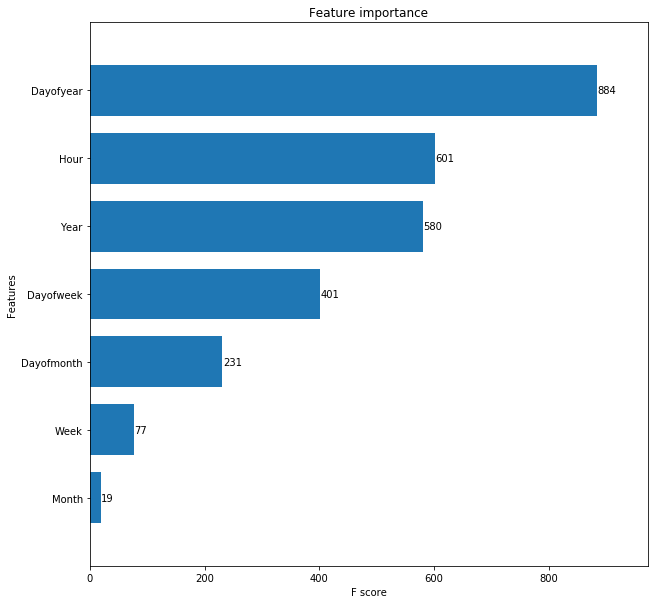

In [17]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']
X_test = test.loc[:, 'Year':]

model = xgb.XGBRegressor(silent=True, n_jobs=3, verbose = False)

rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = num_iter,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')


model = xgb.XGBRegressor(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit3.csv',index=False, header =1)

plt.rcParams["figure.figsize"] = (10, 10)
xgb.plot_importance(model, height = .75, grid = False)
plt.show();

## Comments

XGBoost is significantly slower (about a factor of 4) and less accurate (only slightly).

It also got a score of 156 on the website, which is significantly less accurate. Though this may improve when the full public test set is revealed, there is no reason to think so.

Feature importance is almost identical to lgb random search.

# Conclusion

In the end, the LightGBM model did the best, with a RMSE of 139, putting us in 12th place! The various feature importances also confirmed the patterns we saw in the graphs. Now, we'll see how we do when the competition ends.

The model we've developed would be very helpful in predicting the number of users of this new public transit system, which could help investors value the future returns of the company.